In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
#from keras.utils import to_categorical
from Neural_network import Neural_network_complex as Net
from Random_Qubits import State_Density_Matrix as SDM
import sys

In [2]:
X = np.array([[0,1],[1,0]])
Y = np.array([[0,0-1j],[0+1j,0]])
Z = np.array([[1,0],[0,-1]])
E = np.array([[1,0],[0,1]])
base=np.zeros((4,2,2),complex)
base[0,:,:]=X
base[1,:,:]=Y
base[2,:,:]=Z
base[3,:,:]=E
print(base)

[[[ 0.+0.j  1.+0.j]
  [ 1.+0.j  0.+0.j]]

 [[ 0.+0.j  0.-1.j]
  [ 0.+1.j  0.+0.j]]

 [[ 1.+0.j  0.+0.j]
  [ 0.+0.j -1.+0.j]]

 [[ 1.+0.j  0.+0.j]
  [ 0.+0.j  1.+0.j]]]


In [3]:
G2werer_train=np.load('Random_Qubits/density_matrix/60000__generalized_werner2.npz')['densitymatrix']
G2label_train=np.load('Random_Qubits/density_matrix/labels_of_60000__generalized_werner2.npz')['PPT']
G2werer_test=np.load('Random_Qubits/density_matrix/10000__test_generalized_werner2.npz')['densitymatrix']
G2label_test=np.load('Random_Qubits/density_matrix/labels_of_10000__test_generalized_werner2.npz')['PPT']
G2label_train=G2label_train[0]
G2label_test=G2label_test[0]
print(G2werer_train.shape)
print(G2label_train.shape)
print(G2werer_test.shape)
print(G2label_test.shape)

def label2D_for_twoclassify(label):
    y=np.zeros((1,label.shape[0]))
    y[0]=label
    return y

G2Werer_train=G2werer_train
G2Label_train=label2D_for_twoclassify(G2label_train)
G2Werer_test=G2werer_test
G2Label_test=label2D_for_twoclassify(G2label_test)

print(G2Werer_train.shape)
print(G2Label_train.shape)
print(G2Werer_test.shape)
print(G2Label_test.shape)

(60000, 4, 4)
(60000,)
(10000, 4, 4)
(10000,)
(60000, 4, 4)
(1, 60000)
(10000, 4, 4)
(1, 10000)


In [4]:
class Convolution:
    def __init__(self,w,b,stride_w=1,stride_h=1,pad=0,dtype=float):
        self.dtype=dtype
        self.w=w
        self.b=b
        self.stride_w=stride_w
        self.stride_h=stride_h
        self.pad=pad
        
        self.img=None
        self.col=None
        self.col_w=None
        self.imgshape=None
    
    def forward(self,img):
        N, C, H, W = img.shape
        FN, C, FH, FW = self.w.shape
        self.img=img
        self.imgshape=img.shape
        OH=(H+2*self.pad-FH)//self.stride_h+1
        OW=(W+2*self.pad-FW)//self.stride_w+1
        img=np.pad(img,[(0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)],'constant')
        col=np.zeros((N,C,FH,FW,OH,OW),self.dtype)
        col_w=self.w.reshape(FN,-1).T#变成FN列 C*FH*FW行
        for y in range(FH):
            y_max=y+self.stride_h*OH
            for x in range(FW):
                x_max=x+self.stride_w*OW
                col[:,:,y,x,:,:]=img[:,:,y:y_max:self.stride_h,x:x_max:self.stride_w]  #每个x y对应共OH*OW*N*C个元素
        col=col.transpose(0,4,5,1,2,3).reshape(N*OH*OW,-1)#C*FH*FW列       
        
        out=np.dot(col,col_w)+self.b#N*OH*OW行 FN列
        out=out.reshape(N,OH,OW,FN).transpose(0,3,1,2)#转为数量 通道 行 列 N FN OH OWd
        
        self.col=col
        self.col_w=col_w
        return out
    
    def backward(self,delta):#delta为N FN OH OW  
        FN, C, FH, FW = self.w.shape
        N,FN,OH,OW=delta.shape
        #print('inner delta',delta)
        delta=delta.transpose(0,2,3,1).reshape(-1,FN)#变成N*OH*OW FN
        #print('self.col',self.col)
        db=np.sum(delta,axis=0)/N  #也就是在列上求sum 输出FN长度的一维数组
        dw=np.dot(self.col.T,delta)/N
        dw=dw.transpose(1,0).reshape(FN, C, FH, FW)
        #print('inner dw',dw)
        dcol=np.dot(delta,self.col_w.T)  #N*OH*OW C*FH*FW
        #dx = col2im(dcol, self.xshape, self.pool_h, self.pool_w, self.stride, self.pad)
        N, C, H, W = self.imgshape
        #OH=(H+2*self.pad-FH)//self.stride+1
        #OW=(W+2*self.pad-FW)//self.stride+1
        dcol=dcol.reshape(N,OH,OW,C,FH,FW).transpose(0,3,4,5,1,2)
        delta_next=np.zeros((N,C,H+2*self.pad+self.stride_h-1,W+2*self.pad+self.stride_w-1),self.dtype)
        
        for y in range(FH):
            y_max=y+self.stride_h*OH
            for x in range(FW):
                x_max=x+self.stride_w*OW
                delta_next[:,:,y:y_max:self.stride_h, x:x_max:self.stride_w]+=dcol[:,:,y,x,:,:]
        return delta_next[:,:,self.pad:H+self.pad,self.pad:W+self.pad],dw,db

In [5]:
class Hermite_Measure_TII:
    def __init__(self,n,meas,Base):  #Base-[(meas,n,FN,C,FH,FW)=(meas,n,1,1,2,2)]
        self.n=n
        self.meas=meas
        self.X = np.array([[0,1],[1,0]])
        self.Y = np.array([[0,0-1j],[0+1j,0]])
        self.Z = np.array([[1,0],[0,-1]])
        self.E = np.array([[1,0],[0,1]])
        self.Base_w=Base  #Base-[(meas,n,FN,C,FH,FW)=(meas,n,1,1,2,2)]
        #print('self.Base_w',self.Base_w,self.Base_w.shape)
        #print(self.Base_w[0,0],self.Base_w[0,0].shape)
        
    def forward(self,sigma):#sigma要求 （N,H,W）
        self.N=sigma.shape[0]
        self.ConV=[]#各个卷积层所在
        out=np.zeros((self.meas,self.N))
        
        sigma_in=sigma.reshape((1,self.N,sigma.shape[1],sigma.shape[2])).transpose(1,0,2,3)#(N,1,H,W)
        for mea in range(self.meas):
            mea_Conv=[]#当前测量的卷积层列表
            mea_Conv_in=[sigma_in]
            for parti in range(self.n):
           #     print('mea=',mea,'parti=',parti,'_Conv_in_',mea_Conv_in[-1],mea_Conv_in[-1].shape)
                mea_Conv.append(Convolution(self.Base_w[mea,parti],b=np.array([0]),stride_w=2,stride_h=2,dtype=complex))
                conv_out=mea_Conv[-1].forward(mea_Conv_in[-1])#（N 1 H W）*（1 1 2 2）=(N 1 H/2 W/2)
                #print('conv_out',conv_out,conv_out.shape)  #所有parti轮完一定是(N 1 1 1)
                mea_Conv_in.append(conv_out)   #所有parti轮完一定是(N 1 1 1)
            self.ConV.append(mea_Conv)
            out[mea,:]=np.real(conv_out[:,0,0,0].reshape(self.N))
        #print('out')
        #print(len(self.ConV),len(self.ConV[0]))
        return out
    
    def backward(self,delta):#delta形状应为(meas,N) 和out相同
        dBase_w=np.zeros(self.Base_w.shape,complex)  #w是优化参数一个长度n数组：w=(meas, n, 1, 1, 2, 2)
        
        for mea in range(self.meas):
            delta_mea=delta[mea,:].reshape(self.N,1,1,1)  #(N 1 H/2 W/2)
            #print('delta_mea',delta_mea)
            for parti in range(1,self.n+1):
                #print('mea=',mea+1,'parti=',self.n+1-parti)
                #print('delta_mea_part',delta_mea,delta_mea.shape)
                delta_mea,dBase,db=self.ConV[mea][-parti].backward(delta_mea)  #dbase(1,1,2,2)
                #print('dbase',dBase,dBase.shape)
                #dBase=dBase*self.N  #因为ConV.backward求梯度时已经/N了 但此N非self.N，
                dBase_w[mea,-parti]=dBase
                #print('delta_mea',delta_mea,delta_mea.shape)
                #print('delta_mea_part',delta_mea,delta_mea.shape)
        return dBase_w

In [16]:
class NetWork(object):
    def __init__(self,Parti_N,Meas,dtype=complex):
        ###np.random.seed(666)
        self.dtype=dtype
        self.Parti_N=Parti_N  #粒子数
        self.Meas=Meas #测量数
        
        self.X = np.array([[0,1],[1,0]])
        self.Y = np.array([[0,0-1j],[0+1j,0]])
        self.Z = np.array([[1,0],[0,-1]])
        self.E = np.array([[1,0],[0,1]])
        self.base=[self.X.T,self.Y.T,self.Z.T,self.E.T]
        
        self.Hermite_p=np.zeros((Meas,Parti_N,4))
        self.Hermite_p[:,0,:]=np.random.uniform(-np.sqrt(6/(16+4)),np.sqrt(6/(16+4)),self.Hermite_p[:,0,:].shape)
        self.Hermite_p[:,1,:]=np.random.uniform(-np.sqrt(6/(4+1)),np.sqrt(6/(4+1)),self.Hermite_p[:,1,:].shape)
        self.Hermite=np.zeros((Meas,Parti_N,1,1,2,2),complex) #(meas,n,FN,C,FH,FW)
        for mea in range(self.Meas):
            for parti in range(self.Parti_N):
                for i in range(len(self.base)):
                    self.Hermite[mea,parti,:,:]=self.Hermite[mea,parti,:,:]+self.base[i]*self.Hermite_p[mea,parti,i]
        #print(self.Hermite)
        
        self.weights=[np.random.uniform(-np.sqrt(6/(self.Meas+1024)),np.sqrt(6/(self.Meas+1024)),(1024,self.Meas))]
        #self.weights.append(np.random.uniform(-np.sqrt(6/(256+256)),np.sqrt(6/(256+256)),(256,256)))
        #self.weights.append(np.random.uniform(-np.sqrt(6/(100+200)),np.sqrt(6/(100+200)),(100,200)))
        #self.weights.append(np.random.uniform(-np.sqrt(6/(200+200)),np.sqrt(6/(200+200)),(200,200)))
        self.weights.append(np.random.uniform(-np.sqrt(6/(1024+1)),np.sqrt(6/(1024+1)),(1,1024)))
        
        self.biases=[np.random.uniform(-np.sqrt(6/(self.Meas+1024)),np.sqrt(6/(self.Meas+1024)),(1024,1))]#注意是列向量
        #self.biases.append(np.random.uniform(-np.sqrt(6/(256+256)),np.sqrt(6/(256+256)),(256,1)))
        #self.biases.append(np.random.uniform(-np.sqrt(6/(100+200)),np.sqrt(6/(100+200)),(100,1)))
        #self.biases.append(np.random.uniform(-np.sqrt(6/(200+100)),np.sqrt(6/(200+100)),(200,1)))
        self.biases.append(np.random.uniform(-np.sqrt(6/(1024+1)),np.sqrt(6/(1024+1)),(1,1)))
        #print(self.biases[1])
    
    def get_parameter(self):
        return self.Hermite,self.weights,self.biases
    
    def forward(self,x,y):
        self.N=x.shape[0]
        
        self.Hermite_layer=Hermite_Measure_TII(self.Parti_N,self.Meas,self.Hermite)
        #self.sigmoid_lay0=Net.Sigmoid()
        
        self.full_connect_layer1=Net.Affine(self.weights[0],self.biases[0])
        self.sigmoid_lay1=Net.Relu()
        self.full_connect_layer2=Net.Affine(self.weights[1],self.biases[1])
        #self.sigmoid_lay2=Net.Sigmoid()
        #self.full_connect_layer3=Net.Affine(self.weights[2],self.biases[2])
        #self.sigmoid_lay3=Net.Sigmoid()
        #self.full_connect_layer4=Net.Affine(self.weights[3],self.biases[3])
        #self.sigmoid_lay4=Net.Relu()
        #self.full_connect_layer5=Net.Affine(self.weights[4],self.biases[4])
        self.final_layer=Net.SigmoidWithCrossEntropy()
        
        #print('x.shape:',x.shape)
        hermite=self.Hermite_layer.forward(x)  #hermite应该是(Meas,self.N)
        #hermite_a=self.sigmoid_lay0.forward(hermite)
        #print('hermite.shape:',hermite,hermite.shape)
        full_connect1_z=self.full_connect_layer1.forward(hermite)
        full_connect1_a=self.sigmoid_lay1.forward(full_connect1_z)
        #print('full_connect1_a.shape:',full_connect1_a.shape)
        full_connect2_z=self.full_connect_layer2.forward(full_connect1_a)
        #full_connect2_a=self.sigmoid_lay2.forward(full_connect2_z)
        #print('full_connect2_a.shape:',full_connect2_a.shape)
        #full_connect3_z=self.full_connect_layer3.forward(full_connect2_a)
        #full_connect3_a=self.sigmoid_lay3.forward(full_connect3_z)
        #full_connect4_z=self.full_connect_layer4.forward(full_connect3_a)
        #full_connect4_a=self.sigmoid_lay4.forward(full_connect4_z)
        
        #full_connect5_z=self.full_connect_layer5.forward(full_connect4_a)
        out,loss=self.final_layer.forward(full_connect2_z,y)
        #print('full_connect3_z.shape:',full_connect3_z.shape)
        #print('out.shape:',out.shape)
        return out,loss
    
    def backward(self):
        delta=self.final_layer.backward()
        #delta,dFw5,dFb5=self.full_connect_layer5.backward(delta)
        
        #delta=self.sigmoid_lay4.backward(delta)
        #delta,dFw4,dFb4=self.full_connect_layer4.backward(delta)
        
        #delta=self.sigmoid_lay3.backward(delta)
        #delta,dFw3,dFb3=self.full_connect_layer3.backward(delta)
          
        #delta=self.sigmoid_lay2.backward(delta)
        delta,dFw2,dFb2=self.full_connect_layer2.backward(delta)
        
        delta=self.sigmoid_lay1.backward(delta)
        delta,dFw1,dFb1=self.full_connect_layer1.backward(delta)
        
        #delta=self.sigmoid_lay0.backward(delta)
        D_Hp=self.Hermite_layer.backward(delta)   #
        D_Fw=[dFw1,dFw2]#,dFw3]#,dFw4]#,dFw5]
        D_Fb=[dFb1,dFb2]#,dFb3]#,dFb4]#,dFb5]
    
        return D_Fw,D_Fb,D_Hp
    
    def updata_Adam(self,images,labels,test_imag,test_lab,batch_size,epochs,lr=0.001,beta1=0.9,beta2=0.999,epsilon=1e-8):
        # Adaptive Moment Estimation     lr beta1 beta2 epsilon为推荐默认值
        batch_num=math.ceil(images.shape[0]/batch_size)
        LOSS=[]
        #初始化动量
        V_Hp=np.zeros(self.Hermite.shape)
        V_Fw=[np.zeros(fw.shape) for fw in self.weights]
        V_Fb=[np.zeros(fb.shape) for fb in self.biases]
        #初始化累计变量
        S_Hp=np.zeros(self.Hermite.shape)
        S_Fw=[np.zeros(fw.shape) for fw in self.weights]
        S_Fb=[np.zeros(fb.shape) for fb in self.biases]
        for epoch in range(epochs):
            for bn in range(1,batch_num+1):
                b_start=(bn-1)*batch_size
                out,loss=self.forward(images[b_start:b_start+batch_size,:,:],labels[:,b_start:b_start+batch_size])
                LOSS.append(loss)
                D_Fw,D_Fb,D_Hp=self.backward()
                
                V_Hp=V_Hp*beta1+(1-beta1)*D_Hp
                V_Fw=[v_fw*beta1+(1-beta1)*d_fw for v_fw,d_fw in zip(V_Fw,D_Fw)]
                V_Fb=[v_fb*beta1+(1-beta1)*d_fb for v_fb,d_fb in zip(V_Fb,D_Fb)]
                S_Hp=S_Hp*beta2+(1-beta2)*np.power(D_Hp,2)
                S_Fw=[s_fw*beta2+(1-beta2)*np.power(d_fw,2) for s_fw,d_fw in zip(S_Fw,D_Fw)]
                S_Fb=[s_fb*beta2+(1-beta2)*np.power(d_fb,2) for s_fb,d_fb in zip(S_Fb,D_Fb)]
                
                self.Hermite=self.Hermite-lr*(V_Hp/(1-beta1**bn))/(epsilon+np.sqrt(S_Hp/(1-beta2**bn)))
                self.weights=[fw-lr*(v_fw/(1-beta1**bn))/(epsilon+np.sqrt(s_fw/(1-beta2**bn))) for fw,v_fw,s_fw in zip(self.weights,V_Fw,S_Fw)]
                self.biases=[fb-lr*(v_fb/(1-beta1**bn))/(epsilon+np.sqrt(s_fb/(1-beta2**bn))) for fb,v_fb,s_fb in zip(self.biases,V_Fb,S_Fb)]
                
            accuracy,loss=self.evaluate(test_imag,test_lab)
            print('epoch',epoch+1,':__the accuracy is',accuracy,';loss is',loss)
        return np.array(LOSS)
    
    def evaluate(self,images,labels):
        out,loss=self.forward(images,labels)
        result=0
        for num in range(images.shape[0]):
            #if np.argmax(out[:,num])==np.argmax(labels[:,num]):
            if np.abs(out[0,num]-labels[0,num])<0.5:
                result+=1
        return result/labels.shape[1],loss

In [17]:
NW=NetWork(Parti_N=2,Meas=3)
out=NW.forward(G1Werer_train[0:2],G1Label_train[:,0:2])
print(out)
D_Fw,D_Fb,D_Hp=NW.backward()
H,W,B=NW.get_parameter()
print('H',H)
print('B',B)
for w in W:
    print('w',w,w.shape)

(array([[0.52373229, 0.52467567]]), 0.6458746059208476)
H [[[[[[-0.82856614+0.j         -0.31385323-0.30091047j]
     [-0.31385323+0.30091047j -0.04639878+0.j        ]]]]



  [[[[ 0.82022319+0.j         -0.59858141+0.20144491j]
     [-0.59858141-0.20144491j  0.8530087 +0.j        ]]]]]




 [[[[[-0.51882176+0.j          0.47895346+0.24266674j]
     [ 0.47895346-0.24266674j  0.27946172+0.j        ]]]]



  [[[[ 1.65493428+0.j         -0.44264222+1.0309989j ]
     [-0.44264222-1.0309989j  -0.13035089+0.j        ]]]]]




 [[[[[-0.70973152+0.j         -0.13162662+0.25490157j]
     [-0.13162662-0.25490157j -0.22439892+0.j        ]]]]



  [[[[ 0.18945642+0.j          0.98083149+0.7213138j ]
     [ 0.98083149-0.7213138j  -1.62182945+0.j        ]]]]]]
B [array([[-0.0109026 ],
       [-0.0328243 ],
       [-0.01010724],
       ...,
       [-0.00188267],
       [-0.03217055],
       [-0.05499429]]), array([[0.04805625]])]
w [[ 0.0027853   0.06319583  0.01200613]
 [-0.04493276 -0.0388814  -0.0

# Werner

In [12]:
wer_train=np.load('Random_Qubits/density_matrix/60000__Werner_State.npz')['densitymatrix']
lab_train=np.load('Random_Qubits/density_matrix/60000Auto_ent_lab_of_Werner_State.npz')['ENT']
wer_test=np.load('Random_Qubits/density_matrix/10000__test_Werner_State.npz')['densitymatrix']
lab_test=np.load('Random_Qubits/density_matrix/10000Auto_ent_lab_of_test_Werner_State.npz')['ENT']

#lab_train=lab_train[0]
#lab_test=lab_test[0]
print(wer_train.shape)
print(lab_train.shape)
print(wer_test.shape)
print(lab_test.shape)

Wer_train=wer_train
Lab_train=label2D_for_twoclassify(lab_train)
Wer_test=wer_test
Lab_test=label2D_for_twoclassify(lab_test)

print(Wer_train.shape)
print(Lab_train.shape)
print(Wer_test.shape)
print(Lab_test.shape)

(60000, 4, 4)
(60000,)
(10000, 4, 4)
(10000,)
(60000, 4, 4)
(1, 60000)
(10000, 4, 4)
(1, 10000)


epoch 1 :__the accuracy is 0.997 ;loss is 0.008346444283583184
epoch 2 :__the accuracy is 0.9992 ;loss is 0.005029166144231976
epoch 3 :__the accuracy is 0.9991 ;loss is 0.004041505044935312
epoch 4 :__the accuracy is 0.9984 ;loss is 0.003909383643105111
epoch 5 :__the accuracy is 0.9981 ;loss is 0.004196007202009936
epoch 6 :__the accuracy is 0.9978 ;loss is 0.004628177393064045
epoch 7 :__the accuracy is 0.9974 ;loss is 0.005055264255632862
epoch 8 :__the accuracy is 0.9972 ;loss is 0.005410869988944026
epoch 9 :__the accuracy is 0.9969 ;loss is 0.005709883223332532
epoch 10 :__the accuracy is 0.9968 ;loss is 0.005902371539818292
60000


Text(0.5, 0, 'iterations')

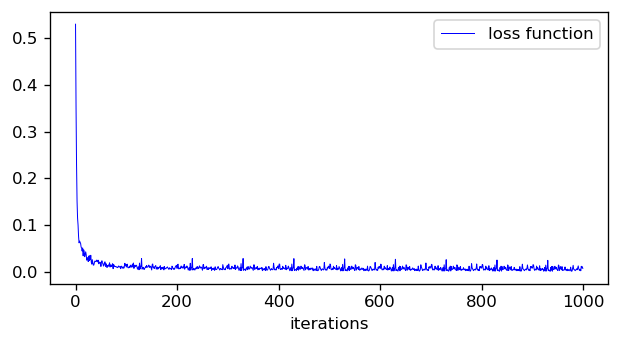

In [13]:
n_mea=1
net0=NetWork(Parti_N=2,Meas=n_mea,dtype=complex)
H0_ini,W0_ini,B0_ini=net0.get_parameter()
LOSS0=net0.updata_Adam(Wer_train,Lab_train,Wer_test,Lab_test,10,10,lr=0.001,beta1=0.9,beta2=0.99)
H0,W0,B0=net0.get_parameter()

print(len(LOSS0))
num=len(LOSS0)//1000 
pic_loss=[np.sum(LOSS0[num*n:num*n+num])/num for n in range(1000)]
fig=plt.figure(figsize=(6,3),dpi=120)
ax=fig.add_subplot(1,1,1,facecolor='white')
ax.plot(np.arange(len(pic_loss)),pic_loss,color='blue',label='loss function',linewidth=0.6)
ax.legend()
ax.set_xlabel('iterations')

n_mea= 4
epoch 1 :__the accuracy is 0.9966 ;loss is 0.009159203973295237
epoch 2 :__the accuracy is 0.9973 ;loss is 0.0062559748546807264
epoch 3 :__the accuracy is 0.9979 ;loss is 0.005082567718424508
epoch 4 :__the accuracy is 0.9987 ;loss is 0.0042505621837468106
epoch 5 :__the accuracy is 0.9992 ;loss is 0.0036712002420792806
epoch 6 :__the accuracy is 0.9998 ;loss is 0.0033786072258579452
epoch 7 :__the accuracy is 0.9993 ;loss is 0.0032730845944039318
epoch 8 :__the accuracy is 0.999 ;loss is 0.003286989094363594
epoch 9 :__the accuracy is 0.9988 ;loss is 0.0033548547157571363
epoch 10 :__the accuracy is 0.9987 ;loss is 0.0034302017522195535
60000
n_mea= 5
epoch 1 :__the accuracy is 0.9978 ;loss is 0.0044511453759999795
epoch 2 :__the accuracy is 0.9971 ;loss is 0.005490481909318698
epoch 3 :__the accuracy is 0.9965 ;loss is 0.0066812935815739535
epoch 4 :__the accuracy is 0.9965 ;loss is 0.006634358831859504
epoch 5 :__the accuracy is 0.9965 ;loss is 0.006505334614316823
epoch 6

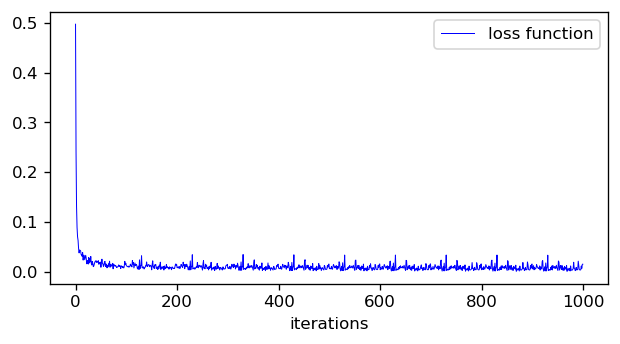

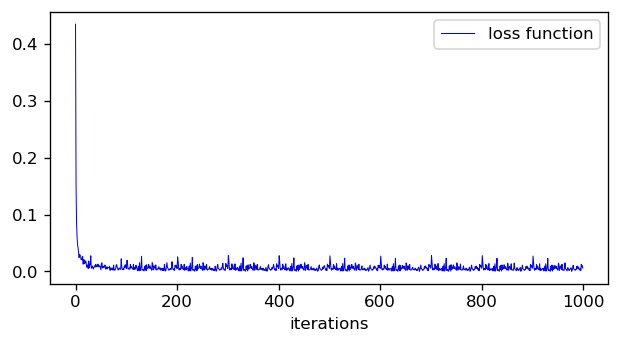

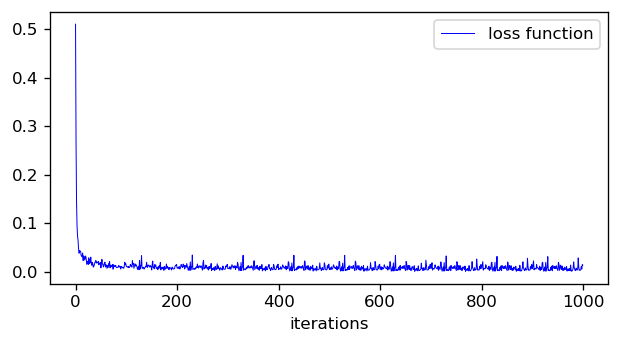

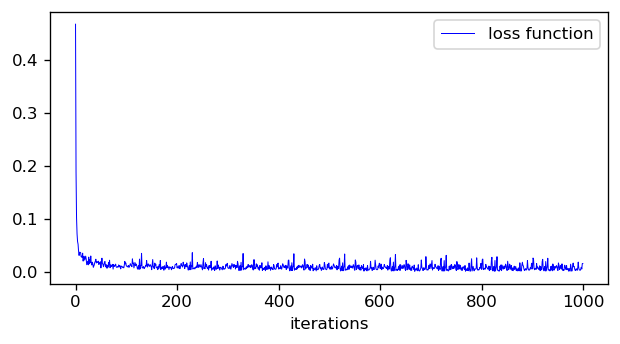

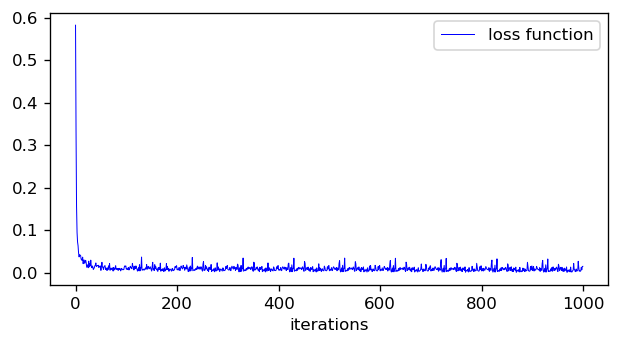

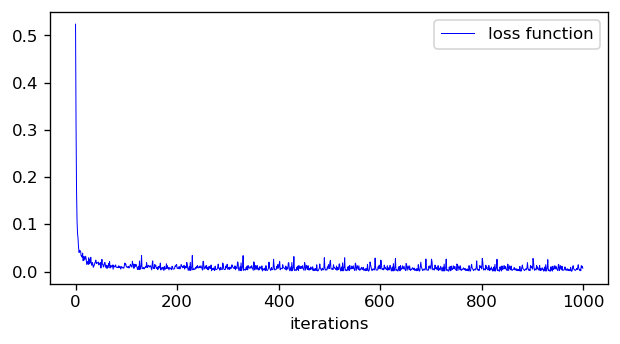

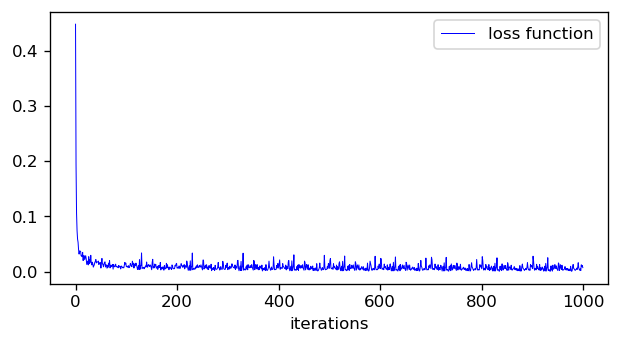

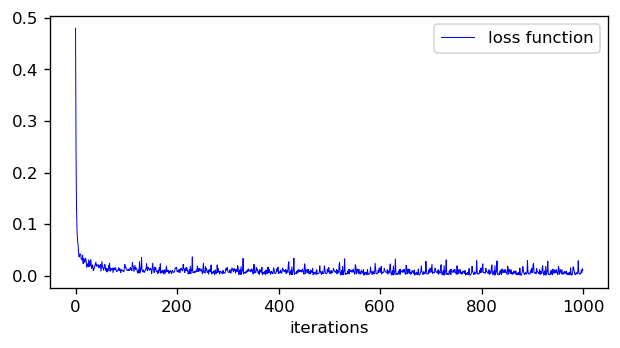

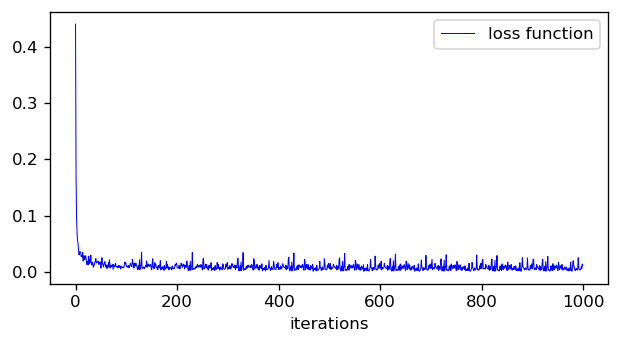

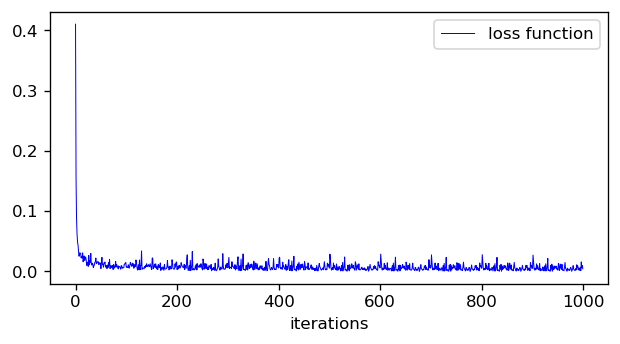

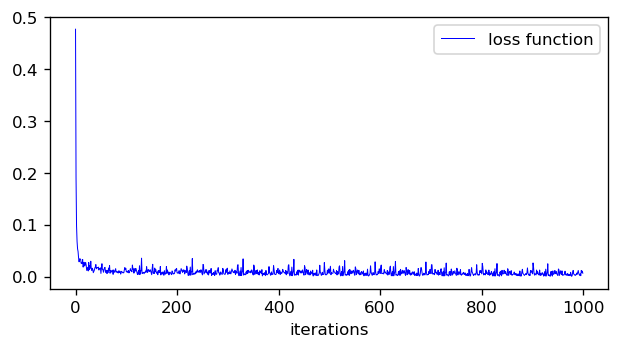

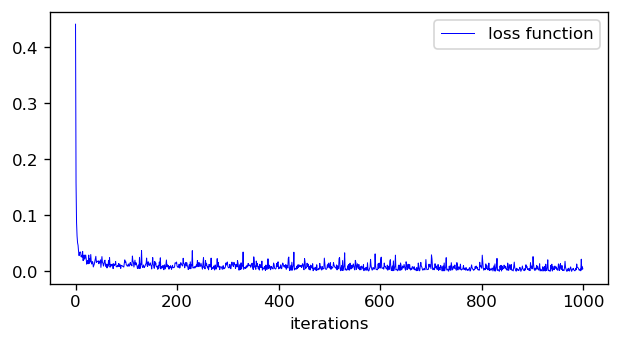

In [32]:
#  1到15个测量量   [隐藏层 1024 Relu ]
for n_mea in range(1,16):
    print('n_mea=',n_mea)
    net0=NetWork(Parti_N=2,Meas=n_mea,dtype=complex)
    H0_ini,W0_ini,B0_ini=net0.get_parameter()
    LOSS0=net0.updata_Adam(Wer_train,Lab_train,Wer_test,Lab_test,10,10,lr=0.001,beta1=0.9,beta2=0.99)
    H0,W0,B0=net0.get_parameter()

    print(len(LOSS0))
    num=len(LOSS0)//1000 
    pic_loss=[np.sum(LOSS0[num*n:num*n+num])/num for n in range(1000)]
    fig=plt.figure(figsize=(6,3),dpi=120)
    ax=fig.add_subplot(1,1,1,facecolor='white')
    ax.plot(np.arange(len(pic_loss)),pic_loss,color='blue',label='loss function',linewidth=0.6)
    ax.legend()
    ax.set_xlabel('iterations')
    
'''    np.savez('卷积神经网络对werner分类汇总/1024relu/普通werner/网络参数/'+str(n_mea)+'个测量量/H_of_werner',H=H0)
    np.savez('卷积神经网络对werner分类汇总/1024relu/普通werner/网络参数/'+str(n_mea)+'个测量量/Loss_of_werner',Loss=LOSS0)
    for i in range(2):
        np.savez('卷积神经网络对werner分类汇总/1024relu/普通werner/网络参数/'+str(n_mea)+'个测量量/W'+str(i)+'_of_werner',W=W0[i])
        np.savez('卷积神经网络对werner分类汇总/1024relu/普通werner/网络参数/'+str(n_mea)+'个测量量/B'+str(i)+'_of_werner',B=B0[i])'''

In [29]:
#print('Hermite',H0_ini.shape,H0_ini)
#print('Hermite',H0.shape,H0)
np.savez('卷积神经网络对werner分类汇总/1024relu/普通werner/网络参数/'+str(n_mea)+'个测量量/H_of_werner',H=H0)
np.savez('卷积神经网络对werner分类汇总/1024relu/普通werner/网络参数/'+str(n_mea)+'个测量量/Loss_of_werner',Loss=LOSS0)
for i in range(2):
    np.savez('卷积神经网络对werner分类汇总/1024relu/普通werner/网络参数/'+str(n_mea)+'个测量量/W'+str(i)+'_of_werner',W=W0[i])
    np.savez('卷积神经网络对werner分类汇总/1024relu/普通werner/网络参数/'+str(n_mea)+'个测量量/B'+str(i)+'_of_werner',B=B0[i])

In [103]:
a=np.load('卷积神经网络对werner分类汇总/普通werner/网络参数/B1_of_werner.npz')['B']
print(np.allclose(a,B0[1]))
lo=np.load('卷积神经网络对werner分类汇总/普通werner/网络参数/Loss_of_werner.npz')['Loss']
print(np.allclose(lo,np.array(LOSS0)))

True
True


In [15]:
H0[0,0,:,0,0]

array([[2.2483022+0.j        , 0.4864951-0.17774675j]])

## G2_Werner

In [115]:
G2werer_train=np.load('Random_Qubits/density_matrix/60000__generalized_werner2.npz')['densitymatrix']
G2label_train=np.load('Random_Qubits/density_matrix/labels_of_60000__generalized_werner2.npz')['PPT']
G2werer_test=np.load('Random_Qubits/density_matrix/10000__test_generalized_werner2.npz')['densitymatrix']
G2label_test=np.load('Random_Qubits/density_matrix/labels_of_10000__test_generalized_werner2.npz')['PPT']
G2label_train=G2label_train[0]
G2label_test=G2label_test[0]
print(G2werer_train.shape)
print(G2label_train.shape)
print(G2werer_test.shape)
print(G2label_test.shape)

def label2D_for_twoclassify(label):
    y=np.zeros((1,label.shape[0]))
    y[0]=label
    return y

G2Werer_train=G2werer_train
G2Label_train=label2D_for_twoclassify(G2label_train)
G2Werer_test=G2werer_test
G2Label_test=label2D_for_twoclassify(G2label_test)

print(G2Werer_train.shape)
print(G2Label_train.shape)
print(G2Werer_test.shape)
print(G2Label_test.shape)

(60000, 4, 4)
(60000,)
(10000, 4, 4)
(10000,)
(60000, 4, 4)
(1, 60000)
(10000, 4, 4)
(1, 10000)


epoch 1 :__the accuracy is 0.9861 ;loss is 0.044557674638092466
epoch 2 :__the accuracy is 0.991 ;loss is 0.023968570141314257
epoch 3 :__the accuracy is 0.9919 ;loss is 0.018716899758989772
epoch 4 :__the accuracy is 0.9949 ;loss is 0.013076273305824981
epoch 5 :__the accuracy is 0.9956 ;loss is 0.011312604997850924
epoch 6 :__the accuracy is 0.9963 ;loss is 0.010502592537954061
epoch 7 :__the accuracy is 0.9962 ;loss is 0.009916995158793625
epoch 8 :__the accuracy is 0.9955 ;loss is 0.010205715844893399
epoch 9 :__the accuracy is 0.9956 ;loss is 0.010328874182450615
epoch 10 :__the accuracy is 0.9958 ;loss is 0.009965857429094198
60000


Text(0.5, 0, 'iterations')

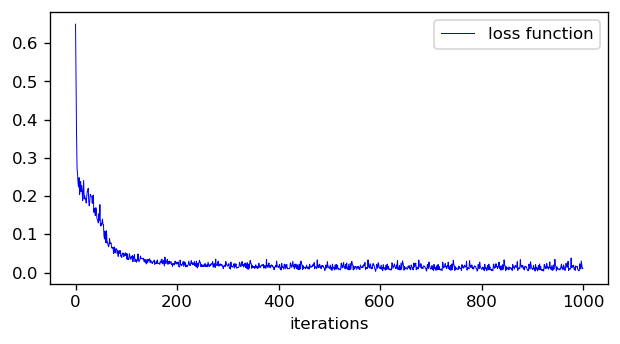

In [117]:
# 3个测量量对G2 werner [隐藏层 1024 Relu ]
# 10,10,lr=0.001,beta1=0.3,beta2=0.9
#,10,10,lr=0.001,beta1=0.35,beta2=0.99  99.14
# 10,10,lr=0.001,beta1=0.4,beta2=0.99 99.05
net1=NetWork(Parti_N=2,Meas=3,dtype=complex)
H1_ini,W1_ini,B1_ini=net1.get_parameter()
LOSS1=net1.updata_Adam(G2Werer_train,G2Label_train,G2Werer_test,G2Label_test,10,10,lr=0.001,beta1=0.375,beta2=0.99)
H1,W1,B1=net1.get_parameter()

print(len(LOSS1))
num=len(LOSS1)//1000 
pic_loss=[np.sum(LOSS1[num*n:num*n+num])/num for n in range(1000)]
fig=plt.figure(figsize=(6,3),dpi=120)
ax=fig.add_subplot(1,1,1,facecolor='white')
ax.plot(np.arange(len(pic_loss)),pic_loss,color='blue',label='loss function',linewidth=0.6)
ax.legend()
ax.set_xlabel('iterations')

In [118]:
np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/3个测量量/H_of_G2werner',H=H1)
np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/3个测量量/Loss_of_G2werner',Loss=LOSS1)
for i in range(2):
    np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/3个测量量/W'+str(i)+'_of_G2werner',W=W1[i])
    np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/3个测量量/B'+str(i)+'_of_G2werner',B=B1[i])

epoch 1 :__the accuracy is 0.8619 ;loss is 0.3156647708711951
epoch 2 :__the accuracy is 0.8941 ;loss is 0.2529771140843413
epoch 3 :__the accuracy is 0.9313 ;loss is 0.17790981826199095
epoch 4 :__the accuracy is 0.9412 ;loss is 0.14534292555489892
epoch 5 :__the accuracy is 0.9466 ;loss is 0.12880842660802796
epoch 6 :__the accuracy is 0.9523 ;loss is 0.11662831474229993
epoch 7 :__the accuracy is 0.9565 ;loss is 0.10811700050451475
epoch 8 :__the accuracy is 0.9593 ;loss is 0.10057039312823346
epoch 9 :__the accuracy is 0.9619 ;loss is 0.09456414222230718
epoch 10 :__the accuracy is 0.9651 ;loss is 0.08924247972194424
epoch 11 :__the accuracy is 0.9675 ;loss is 0.08458781467436928
epoch 12 :__the accuracy is 0.9679 ;loss is 0.08112206977425213
epoch 13 :__the accuracy is 0.9686 ;loss is 0.07846732771072057
epoch 14 :__the accuracy is 0.9692 ;loss is 0.07600634883423903
epoch 15 :__the accuracy is 0.9699 ;loss is 0.07381930167712149
epoch 16 :__the accuracy is 0.971 ;loss is 0.071618

Text(0.5, 0, 'iterations')

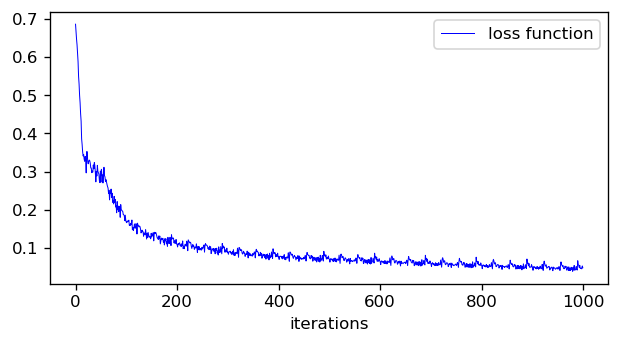

In [102]:
#  2个测量量对G2 Werner  [隐藏层 1024 Relu ]
#   16,10,lr=0.0005,beta1=0.1,beta2=0.3    ——92-94%
#  16,10,lr=0.00025,beta1=0.01,beta2=0.1——95%
# 16,10,lr=0.00025,beta1=0.0001,beta2=0.01——94%
# 10,10,lr=0.001,beta1=0.3,beta2=0.9
# 16,30,lr=0.00025,beta1=0.01,beta2=0.048  96.6
# 16,30,lr=0.00025,beta1=0.015,beta2=0.05  96or97.62
# 10,30,lr=0.00025,beta1=0.0003,beta2=0.048  95 96
# ,250,30,lr=0.001,beta1=0.9,beta2=0.95
net1_1=NetWork(Parti_N=2,Meas=2,dtype=complex)
LOSS1_1=net1_1.updata_Adam(G2Werer_train,G2Label_train,G2Werer_test,G2Label_test,200,30,lr=0.001,beta1=0.9,beta2=0.99)
H1_1,W1_1,B1_1=net1_1.get_parameter()

print(len(LOSS1_1))
num=len(LOSS1_1)//1000 
pic_loss=[np.sum(LOSS1_1[num*n:num*n+num])/num for n in range(1000)]
fig=plt.figure(figsize=(6,3),dpi=120)
ax=fig.add_subplot(1,1,1,facecolor='white')
ax.plot(np.arange(len(pic_loss)),pic_loss,color='blue',label='loss function',linewidth=0.6)
ax.legend()
ax.set_xlabel('iterations')

In [105]:
np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/2个测量量/更多/98.45/H_of_G2werner',H=H1_1)
np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/2个测量量/更多/98.45/Loss_of_G2werner',Loss=LOSS1_1)
for i in range(2):
    np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/2个测量量/更多/98.45/W'+str(i)+'_of_G2werner',W=W1_1[i])
    np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/2个测量量/更多/98.45/B'+str(i)+'_of_G2werner',B=B1_1[i])

epoch 1 :__the accuracy is 0.8601 ;loss is 0.32739836414991574
epoch 2 :__the accuracy is 0.8577 ;loss is 0.3348403435108652
epoch 3 :__the accuracy is 0.8569 ;loss is 0.3361834756199708
epoch 4 :__the accuracy is 0.8561 ;loss is 0.33701689359529985
epoch 5 :__the accuracy is 0.8561 ;loss is 0.33657106887336213
epoch 6 :__the accuracy is 0.8553 ;loss is 0.3345189608451943
epoch 7 :__the accuracy is 0.8565 ;loss is 0.33200967466053505
epoch 8 :__the accuracy is 0.8502 ;loss is 0.33190652158544093
epoch 9 :__the accuracy is 0.8557 ;loss is 0.33232817854439195
epoch 10 :__the accuracy is 0.854 ;loss is 0.3300191029592064
60000


Text(0.5, 0, 'iterations')

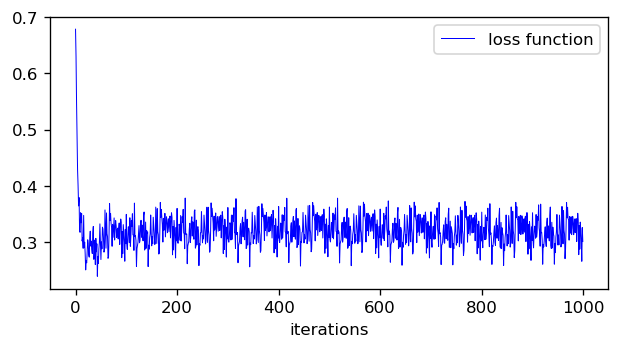

In [108]:
#  1个测量量对G2 Werner
# 10,10,lr=0.001,beta1=0.8,beta2=0.98
#10,10,lr=0.001,beta1=0.5,beta2=0.9
net1_2=NetWork(Parti_N=2,Meas=1,dtype=complex)
LOSS1_2=net1_2.updata_Adam(G2Werer_train,G2Label_train,G2Werer_test,G2Label_test,10,10,lr=0.001,beta1=0.5,beta2=0.9)
H1_2,W1_2,B1_2=net1_2.get_parameter()

print(len(LOSS1_2))
num=len(LOSS1_2)//1000 
pic_loss=[np.sum(LOSS1_2[num*n:num*n+num])/num for n in range(1000)]
fig=plt.figure(figsize=(6,3),dpi=120)
ax=fig.add_subplot(1,1,1,facecolor='white')
ax.plot(np.arange(len(pic_loss)),pic_loss,color='blue',label='loss function',linewidth=0.6)
ax.legend()
ax.set_xlabel('iterations')

In [109]:
np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/1个测量量/H_of_G2werner',H=H1_2)
np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/1个测量量/Loss_of_G2werner',Loss=LOSS1_2)
for i in range(2):
    np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/1个测量量/W'+str(i)+'_of_G2werner',W=W1_2[i])
    np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/1个测量量/B'+str(i)+'_of_G2werner',B=B1_2[i])

epoch 1 :__the accuracy is 0.9931 ;loss is 0.0255566305229507
epoch 2 :__the accuracy is 0.9915 ;loss is 0.02182002200209256
epoch 3 :__the accuracy is 0.993 ;loss is 0.017565853348905563
epoch 4 :__the accuracy is 0.9938 ;loss is 0.015698962074800028
epoch 5 :__the accuracy is 0.9932 ;loss is 0.015245745782442952
epoch 6 :__the accuracy is 0.994 ;loss is 0.013518438601541186
epoch 7 :__the accuracy is 0.9951 ;loss is 0.012221828007330581
epoch 8 :__the accuracy is 0.9952 ;loss is 0.011604328832463632
epoch 9 :__the accuracy is 0.9951 ;loss is 0.011261393711016157
epoch 10 :__the accuracy is 0.9948 ;loss is 0.011538172260720203
60000


Text(0.5, 0, 'iterations')

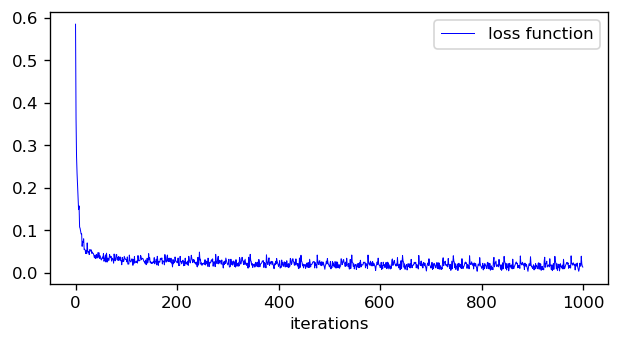

In [123]:
#  4到15个测量量对G1 Werner  [隐藏层 1024 Relu ]
# 10,10,lr=0.001,beta1=0.3,beta2=0.9
Meament=15
net1_3=NetWork(Parti_N=2,Meas=Meament,dtype=complex)
LOSS1_3=net1_3.updata_Adam(G2Werer_train,G2Label_train,G2Werer_test,G2Label_test,10,10,lr=0.001,beta1=0.375,beta2=0.99)
H1_3,W1_3,B1_3=net1_3.get_parameter()

print(len(LOSS1_3))
num=len(LOSS1_3)//1000 
pic_loss=[np.sum(LOSS1_3[num*n:num*n+num])/num for n in range(1000)]
fig=plt.figure(figsize=(6,3),dpi=120)
ax=fig.add_subplot(1,1,1,facecolor='white')
ax.plot(np.arange(len(pic_loss)),pic_loss,color='blue',label='loss function',linewidth=0.6)
ax.legend()
ax.set_xlabel('iterations')

In [89]:
np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/'+str(Meament)+'个测量量/H_of_G2werner',H=H1_3)
np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/'+str(Meament)+'个测量量/Loss_of_G2werner',Loss=LOSS1_3)
for i in range(2):
    np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/'+str(Meament)+'个测量量/W'+str(i)+'_of_G2werner',W=W1_3[i])
    np.savez('卷积神经网络对werner分类汇总/1024relu/G2_werner/网络参数/'+str(Meament)+'个测量量/B'+str(i)+'_of_G2werner',B=B1_3[i])

# G1_Werner

In [18]:
G1werer_train=np.load('Random_Qubits/density_matrix/60000__generalized_werner1.npz')['densitymatrix']
G1label_train=np.load('Random_Qubits/density_matrix/entangle_labels_of_60000__generalized_werner1.npz')['PPT']
G1werer_test=np.load('Random_Qubits/density_matrix/10000__test_generalized_werner1.npz')['densitymatrix']
G1label_test=np.load('Random_Qubits/density_matrix/entangle_labels_of_10000__test_generalized_werner1.npz')['PPT']

G1label_train=G1label_train[0]
G1label_test=G1label_test[0]
print(G1werer_train.shape)
print(G1label_train.shape)
print(G1werer_test.shape)
print(G1label_test.shape)

#预处理
G1Werer_train=G1werer_train
G1Label_train=label2D_for_twoclassify(G1label_train)
G1Werer_test=G1werer_test
G1Label_test=label2D_for_twoclassify(G1label_test)

print(G1Werer_train.shape)
print(G1Label_train.shape)
print(G1Werer_test.shape)
print(G1Label_test.shape)

(60000, 4, 4)
(60000,)
(10000, 4, 4)
(10000,)
(60000, 4, 4)
(1, 60000)
(10000, 4, 4)
(1, 10000)


epoch 1 :__the accuracy is 0.994 ;loss is 0.02734629639456598
epoch 2 :__the accuracy is 0.9943 ;loss is 0.018724810991227712
epoch 3 :__the accuracy is 0.9958 ;loss is 0.01503419541335091
epoch 4 :__the accuracy is 0.9963 ;loss is 0.012807482806932583
epoch 5 :__the accuracy is 0.9967 ;loss is 0.01134958062528409
epoch 6 :__the accuracy is 0.9971 ;loss is 0.010368047540823471
epoch 7 :__the accuracy is 0.9971 ;loss is 0.009627091934211907
epoch 8 :__the accuracy is 0.9971 ;loss is 0.00909683454289271
epoch 9 :__the accuracy is 0.9969 ;loss is 0.008657583916427111
epoch 10 :__the accuracy is 0.9973 ;loss is 0.008321018664401022
60000


Text(0.5, 0, 'iterations')

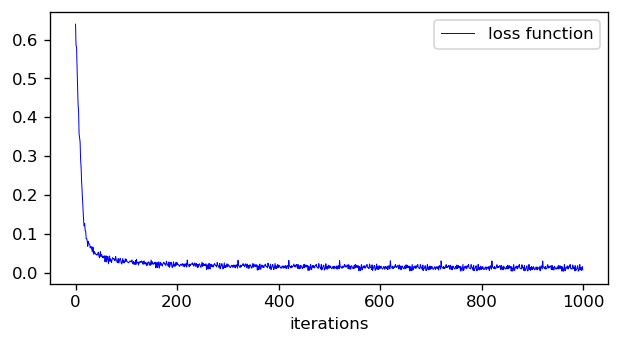

In [77]:
# G1 wener 两个测量量  [隐藏层 1024 Relu ]
# 10,10,lr=0.001,beta1=0.9,beta2=0.9
net2=NetWork(Parti_N=2,Meas=2,dtype=complex)
LOSS2=net2.updata_Adam(G1Werer_train,G1Label_train,G1Werer_test,G1Label_test,10,10,lr=0.001,beta1=0.35,beta2=0.99)
H2,W2,B2=net2.get_parameter()

print(len(LOSS2))
num=len(LOSS2)//1000 
pic_loss=[np.sum(LOSS2[num*n:num*n+num])/num for n in range(1000)]
fig=plt.figure(figsize=(6,3),dpi=120)
ax=fig.add_subplot(1,1,1,facecolor='white')
ax.plot(np.arange(len(pic_loss)),pic_loss,color='blue',label='loss function',linewidth=0.6)
ax.legend()
ax.set_xlabel('iterations')

In [110]:
np.savez('卷积神经网络对werner分类汇总/1024relu/G1_werner/网络参数/2个测量量/H_of_G1werner',H=H2)
np.savez('卷积神经网络对werner分类汇总/1024relu/G1_werner/网络参数/2个测量量/Loss_of_G1werner',Loss=LOSS2)
for i in range(2):
    np.savez('卷积神经网络对werner分类汇总/1024relu/G1_werner/网络参数/2个测量量/W'+str(i)+'_of_G1werner',W=W2[i])
    np.savez('卷积神经网络对werner分类汇总/1024relu/G1_werner/网络参数/2个测量量/B'+str(i)+'_of_G1werner',B=B2[i])

epoch 1 :__the accuracy is 0.9947 ;loss is 0.015494100786044296
epoch 2 :__the accuracy is 0.9952 ;loss is 0.01113205651659423
epoch 3 :__the accuracy is 0.9958 ;loss is 0.00908531496017192
epoch 4 :__the accuracy is 0.9961 ;loss is 0.007585099614887258
epoch 5 :__the accuracy is 0.9971 ;loss is 0.006371433750934207
epoch 6 :__the accuracy is 0.998 ;loss is 0.005405039621072253
epoch 7 :__the accuracy is 0.9985 ;loss is 0.004668440551559206
epoch 8 :__the accuracy is 0.999 ;loss is 0.004134157747103246
epoch 9 :__the accuracy is 0.9994 ;loss is 0.0037608726818889712
epoch 10 :__the accuracy is 0.9995 ;loss is 0.0035027533783692825
60000


Text(0.5, 0, 'iterations')

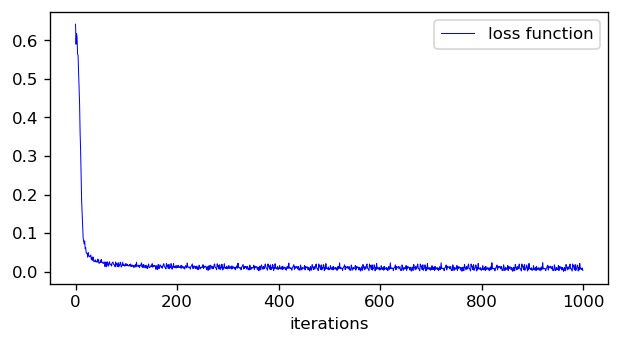

In [19]:
net2_1=NetWork(Parti_N=2,Meas=1,dtype=complex)
LOSS2_1=net2_1.updata_Adam(G1Werer_train,G1Label_train,G1Werer_test,G1Label_test,10,10,lr=0.001,beta1=0.35,beta2=0.99)
H2_1,W2_1,B2_1=net2_1.get_parameter()

print(len(LOSS2_1))
num=len(LOSS2_1)//1000 
pic_loss=[np.sum(LOSS2_1[num*n:num*n+num])/num for n in range(1000)]
fig=plt.figure(figsize=(6,3),dpi=120)
ax=fig.add_subplot(1,1,1,facecolor='white')
ax.plot(np.arange(len(pic_loss)),pic_loss,color='blue',label='loss function',linewidth=0.6)
ax.legend()
ax.set_xlabel('iterations')

epoch 1 :__the accuracy is 0.9937 ;loss is 0.019141348986119876
epoch 2 :__the accuracy is 0.9944 ;loss is 0.012642607533016138
epoch 3 :__the accuracy is 0.9952 ;loss is 0.009859441276819285
epoch 4 :__the accuracy is 0.9961 ;loss is 0.00815523390866395
epoch 5 :__the accuracy is 0.9967 ;loss is 0.006981547350276829
epoch 6 :__the accuracy is 0.9973 ;loss is 0.006099411625560617
epoch 7 :__the accuracy is 0.9974 ;loss is 0.0054113282236683885
epoch 8 :__the accuracy is 0.9977 ;loss is 0.004872648659016811
epoch 9 :__the accuracy is 0.9983 ;loss is 0.004458825130918026
epoch 10 :__the accuracy is 0.9988 ;loss is 0.0041466240150192495
60000


Text(0.5, 0, 'iterations')

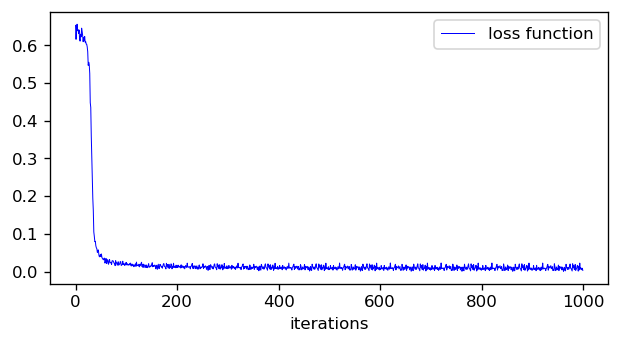

In [78]:
# G1 wener 一个测量量   [隐藏层 1024 Relu ]
# 10,10,lr=0.001,beta1=0.95,beta2=0.9
# 5,10,lr=0.001,beta1=0.95,beta2=0.85
net2_1=NetWork(Parti_N=2,Meas=1,dtype=complex)
LOSS2_1=net2_1.updata_Adam(G1Werer_train,G1Label_train,G1Werer_test,G1Label_test,10,10,lr=0.001,beta1=0.35,beta2=0.99)
H2_1,W2_1,B2_1=net2_1.get_parameter()

print(len(LOSS2_1))
num=len(LOSS2_1)//1000 
pic_loss=[np.sum(LOSS2_1[num*n:num*n+num])/num for n in range(1000)]
fig=plt.figure(figsize=(6,3),dpi=120)
ax=fig.add_subplot(1,1,1,facecolor='white')
ax.plot(np.arange(len(pic_loss)),pic_loss,color='blue',label='loss function',linewidth=0.6)
ax.legend()
ax.set_xlabel('iterations')

In [111]:
np.savez('卷积神经网络对werner分类汇总/1024relu/G1_werner/网络参数/1个测量量/H_of_G1werner',H=H2_1)
np.savez('卷积神经网络对werner分类汇总/1024relu/G1_werner/网络参数/1个测量量/Loss_of_G1werner',Loss=LOSS2_1)
for i in range(2):
    np.savez('卷积神经网络对werner分类汇总/1024relu/G1_werner/网络参数/1个测量量/W'+str(i)+'_of_G1werner',W=W2_1[i])
    np.savez('卷积神经网络对werner分类汇总/1024relu/G1_werner/网络参数/1个测量量/B'+str(i)+'_of_G1werner',B=B2_1[i])

epoch 1 :__the accuracy is 0.9961 ;loss is 0.009185189764660602
epoch 2 :__the accuracy is 0.9984 ;loss is 0.004839200660765306
epoch 3 :__the accuracy is 0.9976 ;loss is 0.004602690398322801
epoch 4 :__the accuracy is 0.9973 ;loss is 0.0049134439939913345
epoch 5 :__the accuracy is 0.9975 ;loss is 0.004880016657423739
epoch 6 :__the accuracy is 0.9978 ;loss is 0.004705246799894216
epoch 7 :__the accuracy is 0.9978 ;loss is 0.004535667480993491
epoch 8 :__the accuracy is 0.9983 ;loss is 0.004309711896866084
epoch 9 :__the accuracy is 0.9983 ;loss is 0.004130591838507568
epoch 10 :__the accuracy is 0.9982 ;loss is 0.0040433087556728566
60000


Text(0.5, 0, 'iterations')

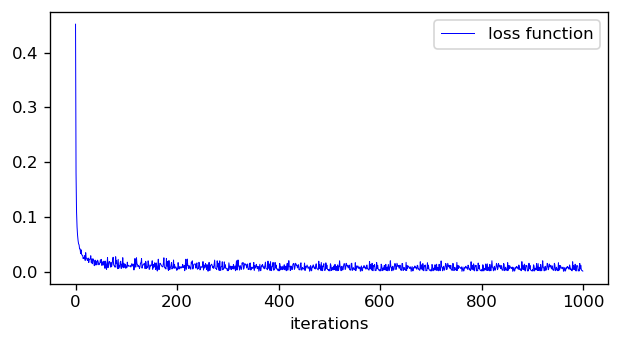

In [122]:
# G1 wener 3到15个测量量   [隐藏层 1024 Relu ]
Meament=15

net2_2=NetWork(Parti_N=2,Meas=Meament,dtype=complex)
LOSS2_2=net2_2.updata_Adam(G1Werer_train,G1Label_train,G1Werer_test,G1Label_test,10,10,lr=0.001,beta1=0.35,beta2=0.99)
H2_2,W2_2,B2_2=net2_2.get_parameter()

print(len(LOSS2_2))
num=len(LOSS2_2)//1000 
pic_loss=[np.sum(LOSS2_2[num*n:num*n+num])/num for n in range(1000)]
fig=plt.figure(figsize=(6,3),dpi=120)
ax=fig.add_subplot(1,1,1,facecolor='white')
ax.plot(np.arange(len(pic_loss)),pic_loss,color='blue',label='loss function',linewidth=0.6)
ax.legend()
ax.set_xlabel('iterations')

In [121]:
np.savez('卷积神经网络对werner分类汇总/1024relu/G1_werner/网络参数/'+str(Meament)+'个测量量/H_of_G1werner',H=H2_2)
np.savez('卷积神经网络对werner分类汇总/1024relu/G1_werner/网络参数/'+str(Meament)+'个测量量/Loss_of_G1werner',Loss=LOSS2_2)
for i in range(2):
    np.savez('卷积神经网络对werner分类汇总/1024relu/G1_werner/网络参数/'+str(Meament)+'个测量量/W'+str(i)+'_of_G1werner',W=W2_2[i])
    np.savez('卷积神经网络对werner分类汇总/1024relu/G1_werner/网络参数/'+str(Meament)+'个测量量/B'+str(i)+'_of_G1werner',B=B2_2[i])